<h1><center>Introduction to Deep Learning with Python Project: Image Generation and Style Transfering</center></h1>

**Authors**: Paul Couairon, Loïc Jourdan, Emma Sarfati

## Introduction

In this notebook, our goal is to implement two main methods linked with image generation. The first one, that we already studied in class but did not see during the lab, is the Generative Adversarial Network model, proposed in the paper of Goodfellow et al. in 2014 **[0]**. The second is based on the paper *A Neural Algorithm of Artistic Style* by Gatys et al. **[1]**. In order to be consistent with the teaching we received, we decided to implement our algorithms using Keras. We wanted to treat general popular topics in computer vision, as it is an interesting field to us. We focus here on generative algorithms based on deep learning.

**Important note**: although a GAN implementation was available in a notebook of the las lab session, we **did not** use it for our project. We tried to design our own code as much as we could. For the style transfer part, we also tried to code by ourselves as much as possible, but to be transparent, it was mainly inspired by the tensorflow version. However, the GAN part is mainly our work. All the code references that we used will be recalled.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#I--Generative-Adversarial-Networks" data-toc-modified-id="I--Generative-Adversarial-Networks-2">I- Generative Adversarial Networks</a></span><ul class="toc-item"><li><span><a href="#I--1.-Some-theory" data-toc-modified-id="I--1.-Some-theory-2.1">I- 1. Some theory</a></span><ul class="toc-item"><li><span><a href="#Motivation" data-toc-modified-id="Motivation-2.1.1">Motivation</a></span></li><li><span><a href="#Mathematical-framework" data-toc-modified-id="Mathematical-framework-2.1.2">Mathematical framework</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2.1.3">Model</a></span></li><li><span><a href="#A-few-theoretical-proofs-of-GAN-convergence" data-toc-modified-id="A-few-theoretical-proofs-of-GAN-convergence-2.1.4">A few theoretical proofs of GAN convergence</a></span></li></ul></li><li><span><a href="#I--2.-The-algorithm" data-toc-modified-id="I--2.-The-algorithm-2.2">I- 2. The algorithm</a></span></li><li><span><a href="#I--3.-Dataset" data-toc-modified-id="I--3.-Dataset-2.3">I- 3. Dataset</a></span></li><li><span><a href="#I--4.-Results" data-toc-modified-id="I--4.-Results-2.4">I- 4. Results</a></span></li></ul></li><li><span><a href="#II--Neural-Style-Transfer" data-toc-modified-id="II--Neural-Style-Transfer-3">II- Neural Style Transfer</a></span><ul class="toc-item"><li><span><a href="#II--1.-Some-theory" data-toc-modified-id="II--1.-Some-theory-3.1">II- 1. Some theory</a></span><ul class="toc-item"><li><span><a href="#Content-recontructions" data-toc-modified-id="Content-recontructions-3.1.1">Content recontructions</a></span></li><li><span><a href="#Style-representation" data-toc-modified-id="Style-representation-3.1.2">Style representation</a></span></li><li><span><a href="#The-global-algorithm" data-toc-modified-id="The-global-algorithm-3.1.3">The global algorithm</a></span></li></ul></li><li><span><a href="#II--2.-Images-to-use" data-toc-modified-id="II--2.-Images-to-use-3.2">II- 2. Images to use</a></span></li><li><span><a href="#II--3.-The-algorithm" data-toc-modified-id="II--3.-The-algorithm-3.3">II- 3. The algorithm</a></span></li><li><span><a href="#II.-4-Results" data-toc-modified-id="II.-4-Results-3.4">II. 4 Results</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-4">References</a></span></li></ul></div>

## I- Generative Adversarial Networks

### I- 1. Some theory

#### Motivation

Image generation is one of the greatest advance in recent works. The problematic is well-known since many years, and it appeared that the deep networks architectures were well-designed for image processing tasks in general, hence for image generation. For instance, Restricted Boltzmann Machines or Deep Belief Networks are deep-learning and physics-inspired probabilistic models that have good ability to generate symbols. However, when it comes to complex images, these structures lack efficiency. Equally, the Autoencoder structures and its variational form suffer the same generalisation issue. Hence, the motivation is to find a structure that is good at understanding hard images in order to reproduce the nuances that they contain. The Generative Adversarial Networks, which training process is inspired by a "fool and learn" procedure, have proved to be a really good answer to image generation issues. 

#### Mathematical framework

The GAN structure is not really far from the Variational Autoencoder one. However, the GAN only contains one decoder, which we call the Generator, denoted $G$. Contrary to the VAE, the latent element $z$ is explicitly sampled from a chosen distribution $p_{z}$, instead of a prior that we wanted to impose in the VAE model. We suppose that the data in the database follows a distribution $p_{\text {data }}$. We want to make the distribution of $x=G(z), p_{G}$ similar to $p_{\text {data }}^{*}$. However, as we know the distribution $p_z$, computing a reconstruction error seems impossible. The solution is then what we call a Discriminator, which is the main idea in the paper of Goodfellow et al. **[0]**.  

If we supppose that we deal with an image as input, of size $m\times n$, the framework is as follows:

- $D: \mathbb{R}^{m n} \rightarrow[0,1]$ is trained to identify "good" (or "true") examples of the data
- $G: \mathbb{R}^{z} \rightarrow \mathbb{R}^{m n}$ is trained to produce realistic data examples
- The two networks are trained at the same time, and each try to fool the other. 

**Loss function**

In order to train such a processus, a Loss function must be defined. The first GAN loss, proposed in the original paper, is the following one :

$$\mathcal{L}(G,D)=\mathbb{E}_{x \sim p_{\text {data }}}[\log D(x)]+\mathbb{E}_{z \sim p_{z}} [ \log (1-D(G(z))) ]$$

which seems pretty intuitive. The first part of the loss must be high since for examples in the true dataset, the discriminator must return a value closed to $1$. The second part of the loss must be closed to $\log 1$ as for randomly generated examples, the discriminator must return a probability closed to $0$. We can note that there, we have two components that have opposite purposes: $G$ must minimize $\mathbb{E}_{z \sim p_{z}} [ \log (1-D(G(z))) ]$ as it tries to force $D$ thinking that its examples are good. On the other hand, $D$ should maximize it as it has to classify examples from $G$ as false examples.  
Since the paper of Goodfellow, many variants of this Loss have proved to be more efficient. For example, the Wasserstein GAN Loss, based on the minimisation of the Wasserstein distance between $p_{data}$ and $p_G$ (the distribution of the generator), improves convergence of the training.  

**Optimisation problem** 

The GAN training is slightly different from usual machine learning algorithm, as it is based on a minmax procedure, following the optimisation purposes for $G$ and $D$ that we described just before. The intuition is that we want to compute parameters of the networks such that:  
- The discriminator can predict properly if an input image is fake or not;
- The generator can generate good image examples.
This leads to the following optimisation algorithm:

\begin{aligned}
\min _{G} \max _{D} & \overbrace{\mathbb{E}_{x \sim p_{\text {data }}}[\log D(x)]}^{D \text { is trying to recognize true data }}+& \underbrace{\mathbb{E}_{z \sim p_{z}}[\log (1-D(G(z)))]}_{G \text { is trying to fool $D$, but $D$ is trying not to be fooled} } \end{aligned}

#### Model

<img src='ganarchitecture.png'>

#### A few theoretical proofs of GAN convergence 

**Convergence properties**: Are we sure that this loss and optimisation problem is well-designed for the purpose of image generation ? Some mathematical results about GAN algorithms convergence can be proved without a lot of difficulty. It has gained interest in the litterature **[2]**.

**Lemma 1** For a fixed $G,$ the optimal $D$ is $\displaystyle D^{*}(x)=\frac{p_{\text {data }}(x)}{p_{\text {data }}(x)+p_{G}(x)}$  

*Proof* 
\begin{aligned}
\mathcal{L}(G, D) &=\mathbb{E}_{x \sim p_{\text {data }}(x)}[\log D(x)]+\mathbb{E}_{z \sim p_{z}(z)}[\log (1-D(G(z)))] \\
&=\int_{x} p_{\text {data }}(x) \log (D(x)) d x+\int_{z} p_{z}(z) \log (1-D(G(z))) d z \\
&=\int_{x} p_{\text {data }}(x) \log (D(x))+p_{G}(x) \log (1-D(x)) d x
\end{aligned}

For every $x,$ the maximum of the previous equation w.r.t $D(x)$ is

$$
D^{*}(x)=\frac{p_{d a t a}(x)}{p_{d a t a}(x)+p_{G}(x)}
$$  


**Theorem 1: optimality theorem** The global optimum of the GAN loss function is achieved if and only if $p_{G}=p_{\text {data }}$. At this point $\mathcal{L}(G, D)=-\log 4$

*Proof* 
1. We are going to prove that if $p_{G}=p_{\text {data }}$, $\mathcal{L}(G, D)=-\log 4$. We can write that  

$$
\begin{aligned}
\max _{D} \mathcal{L}(G, D) &=\mathbb{E}_{x \sim p_{\text {data }}(x)}\left[\log D^{*}(x)\right]+\mathbb{E}_{z \sim p_{z}(z)}\left[\log \left(1-D^{*}(G(z))\right)\right] \\
&=\mathbb{E}_{x \sim p_{\text {data }}(x)}\left[\log \left(\frac{p_{\text {data }}(x)}{p_{\text {data }}(x)+p_{G}(x)}\right)\right]+\mathbb{E}_{x \sim p_{G}(x)}\left[\log \left(\frac{p_{G}(x)}{p_{\text {data }}(x)+p_{G}(x)}\right)\right]
\end{aligned}
$$

   Therefore, if $p_{G}=p_{\text {data }}$, then $\mathcal{L}(G, D)=\log \frac{1}{2}+\log \frac{1}{2}=-\log (4)$


2. Now, we are going to prove that $-\log 4$ is the minimum value of the GAN Loss.  
   First, we remark that :
   
$$
-\log (4)=\mathbb{E}_{x \sim p_{\text {data }}(x)}[-\log (2)]+\mathbb{E}_{x \sim p_{G}(x)}[-\log (2)]
$$

   Therefore, by adding and substracting this expression of $-\log (4)$ from the last equation, we have
   
$$
\begin{aligned}
\mathcal{L}\left(G, D^{*}\right)&=-\log (4)+\mathbb{E}_{x \sim p_{\text {data }}(x)}\left[\log \left(\frac{p_{\text {data }}(x)}{\frac{1}{2}(p_{\text {data }}(x)+p_{G}(x))}\right)\right]+\mathbb{E}_{x \sim p_{G}(x)}\left[\log \left(\frac{p_{G}(x)}{\frac{1}{2}(p_{\text {data }}(x)+p_{G}(x))}\right)\right] \\
&=-\log (4)+ \int p_{\text {data }}(x) \log \frac{p_{\text {data }}(x)}{\frac{1}{2}\left(p_{\text {data }}(x)+p_{G}(x)\right)} d x+ \int p_{G}(x) \log \frac{p_{\text {G}}(x)}{\frac{1}{2}\left(p_{\text {data }}(x)+p_{G}(x)\right)} d x \\
&=-\log (4)+ K L\left(p_{\text {data }} \| \frac{p_{\text {data }}+p_{G}}{2}\right)+K L\left(p_{G} \| \frac{p_{\text {data }}+p_{G}}{2}\right)
\end{aligned}
$$

This can also be rewritten as

$$
\mathcal{L}\left(G, D^{*}\right)=-\log (4)+2 \operatorname{JSD}\left(p_{\text {data }} \| p_{\mathbf{G}}\right)
$$

where JSD is the Jensen-Shannon divergence, which is another distance between distributions. For $p$ and $q$, we have :

$$
\operatorname{JSD}(p, q)=\frac{1}{2} K L\left(p \| \frac{1}{2}(p+q)\right)+\frac{1}{2} K L\left(q \| \frac{1}{2}(p+q)\right)
$$

The Jensen-Shannon divergecne is non-negative and equal to zero if and only if
$p_{\text {data }}=p_{G}$
Therefore $-\log (4)$ is the optimal value, and only reached when $p_{\text {data }}=p_{G}$. This is what we wanted to show.

### I- 2. The algorithm

The optimisation problem, as formulated in (1), is hard to implement in practice (simultaneous minmax problem). We use more classical training procedures to solve the problem, without moving too far away from the original optimisation objective. The GAN training algorithm consists of alternating between discriminator and generator training.  
- The discriminator is first trained during a number $k$ of iterations in order to recognize false and true examples. The false examples are examples that are randomly generated by $G$. As it is a binary classification problem, we use a binary cross entropy as a loss to minimize for the discriminator training. In other words, this "plays the role" of the maximization w.r.t $D$ part in the problem (1).
- When the discriminator step is over, the generator is then trained on fake images from the latent space $z$ in order to improve its ability to generate good images. During this step, we try to minimize $\mathbb{E}_{z \sim p_{z}} [ \log (1-D(G(z))) ]$ (this is the loss we will implement in Keras). This plays the role of the minimization w.r.t $G$ part in (1), and we can note that this is exactly the right part of the GAN loss expression.
- We repeat these alternating steps during a number $n$ of epochs.

$$
\begin{array}{l}
\hline \text { Algorithm 1 GAN training algorithm } \\
\hline \textbf { Data: } X: \text { training image dataset } \\
N: \text { batch size } \\
k: \text { number of inner loop iterations } \\
n: \text { number of optimisation iterations } \\
\quad \textbf { for } i=0 \text { to } n-1 \textbf { do: } \\
\quad\quad \textbf { for } i=0 \text { to } k-1 \textbf { do: } \\
\quad\quad\quad x \leftarrow \text { random_batch }(X, \mathrm{~N}) \\
\quad\quad\quad z \leftarrow \text { random_normal }_{-} \text {vectors }(N) \\
\quad\quad\quad \text { Train discriminator on real images } x \\
\quad\quad\quad \text { Train discriminator on fake images } G(z) \\
\quad\quad\textbf { end for } \\
\quad\quad z \leftarrow \text { random_normal_vectors }(N) \\
\quad\quad\text { Train generator on fake images } G(z) \\
\quad\textbf { end for }
\end{array}
$$

<img src="gan.png">

### I- 3. Dataset 

GAN training is computationally demanding. With a reasonable neural structure for the Discriminator and the Generator, high number of epochs is required to obtain satisfying results. We decided to run our algorithms on the MNIST dataset available on keras. We can check the sizes of the train and test datasets:

In [1]:
import pdb
import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
session = tf.compat.v1.Session(config=config)

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras import backend as K
#from keras.backend.tensorflow_backend import set_session
set_session = tf.compat.v1.keras.backend.set_session(session=session)

In [2]:
mnist.load_data()[0][0].shape

(60000, 28, 28)

In [3]:
mnist.load_data()[1][0].shape

(10000, 28, 28)

Images are grayscale images of size $28\times 28$. Let us plot an digit example:

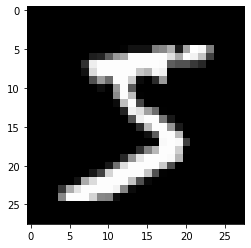

In [4]:
plt.imshow(mnist.load_data()[0][0][0],cmap='gray')
plt.show()

### I- 4. Results

In [5]:
class GAN():
    def __init__(self,learning_rate=0.0002,dataset_name='mnist',load_model_name=''):

        self.learning_rate = learning_rate
        optimizer = Adam(self.learning_rate, 0.5)
        (X_train, _), (_, _) = mnist.load_data()
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        #add a channel dimension as mnist has 2
        X_train = np.expand_dims(X_train, axis=3)

        # default parameters for mnist 
        self.img_rows = X_train.shape[1]
        self.img_cols = X_train.shape[2]
        self.img_channels = X_train.shape[3]
        self.img_shape = (self.img_rows, self.img_cols, self.img_channels)
        self.z_dim = 100
        self.iter_count = 0
        self.dataset_name = dataset_name

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        # set discriminator loss
        self.discriminator.compile(loss='binary_crossentropy',
                                       optimizer=optimizer,
                                       metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()


        # Create the stacked model
        #first, create the random vector z in the latent space
        z = Input(shape=(self.z_dim,))
        #create generated (fake) image
        img = self.generator(z)
        #indicate that for the stacked model, the weights are not trained
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and gives a probability 
        p_true = self.discriminator(img)
        # The combined model  (stacked generator and discriminator)
        # In this model, we train the generator only
        self.adversarial_model = Model(z, p_true)
        # Loss: left part of the loss function written in the notebook
        generator_loss = K.mean(K.log(1-p_true))
        self.adversarial_model.add_loss(generator_loss)
        self.adversarial_model.compile(optimizer=optimizer)
        self.g_losses = []
        self.d_losses = []
        
    def build_generator(self):

        z_rand = Input(shape=(self.z_dim,))
        y = Dense(256)(z_rand)
        y = LeakyReLU(alpha=0.2)(y)
        #y = BatchNormalization(momentum=0.8)(y)
        y = Dense(512)(y)
        y = LeakyReLU(alpha=0.2)(y)
        #y = BatchNormalization(momentum=0.8)(y)
        y = Dense(784)(y)
        y = Activation('tanh')(y) #LeakyReLU(alpha=0.2)(y)
        #y = BatchNormalization(momentum=0.1)(y)
        y = Dense(np.prod(self.img_shape), activation='tanh')(y)
        output_img = Reshape(self.img_shape)(y)

        model_generator = Model(z_rand, output_img)
        model_generator.summary()

        return model_generator

    def build_discriminator(self):

        input_img = Input(shape=self.img_shape)

        y = Flatten(input_shape=self.img_shape)(input_img)
        y = Dense(512)(y)
        #y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU(alpha=0.2)(y)
        y = Dense(256)(y)
        #y = BatchNormalization(momentum=0.1)(y)
        y = LeakyReLU(alpha=0.2)(y)
        p_true = Dense(1, activation='sigmoid')(y)

        model_discriminator = Model(input_img, p_true)
        model_discriminator.summary()

        return model_discriminator
        
    

    def train(self, epochs, batch_size=128, sample_interval=50):
        
        k=1	#number of internal loop
        #load dataset
        (X_train, _), (_, _) = mnist.load_data()
        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        # add a channel dimension as mnist has 2
        X_train = np.expand_dims(X_train, axis=3)
        # Adversarial ground truths
        d_output_true = np.ones((batch_size, 1))    # only "1" because all examples are true
        d_output_false = np.zeros((batch_size, 1))  # only "0" because all examples are false
        first_iter = self.iter_count
        for epoch in range(first_iter,epochs):
            
            # ---------------------
            #  Train Discriminator
            # -------------------
            
            # Train the discriminator
            for i in range(0,k):
                # Step 1: select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]                                         # true images 
                z_random = np.random.normal(0, 1, (batch_size, self.z_dim)) # random vectors
                # Step 2: generate a batch of new (fake) images G(z)
                gen_imgs = self.generator.predict(z_random)                 # fake images from random vectors
                
                # Step 3: train the discriminator on real images 
                d_loss_real = self.discriminator.train_on_batch(imgs, d_output_true)
                # Step 4: train the discriminator on fake images 
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, d_output_false)
                # Compute the discriminator Loss
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                
            # ---------------------
            #  Train Generator
            # -------------------
            
            # Step 1: select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]                                           # true images
            z_random = np.random.normal(0, 1, (batch_size, self.z_dim))   # random vectors
            # Step 2: train the generator (try to make generated images be classified as true by the discriminator)
            g_loss = self.adversarial_model.train_on_batch(z_random,None) # y is set as None as the outputs probas 
                                                                          # are computed at each step
            
            
            # increase epoch counter
            self.iter_count = self.iter_count+1
            # Plot the losses
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            # Stock the losses evolution
            self.g_losses.append(g_loss)
            self.d_losses.append(d_loss)
            # Save some random generated images and the models at every sample_interval iterations
            if (epoch % sample_interval == 0):
                self.sample_images('images/mnist_sample_%06d.png' % epoch)

    def sample_images(self, image_filename, rand_seed=30):
        #np.random.seed(rand_seed)
        r, c = 5, 5
        z_random = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(z_random)
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                #black and white images
                if(gen_imgs.shape[3] == 1):
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                elif(gen_imgs.shape[3] == 3):   #colour images
                    axs[i,j].imshow(gen_imgs[cnt, :,:])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(image_filename)
        plt.close()

In [6]:
gan = GAN()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257   

In [7]:
gan.train(epochs=5001, batch_size=64, sample_interval=50)

0 [D loss: 0.841228, acc.: 36.72%] [G loss: -0.619437]
1 [D loss: 0.511636, acc.: 50.78%] [G loss: -0.805603]
2 [D loss: 0.628289, acc.: 50.00%] [G loss: -1.052275]
3 [D loss: 0.860882, acc.: 50.00%] [G loss: -1.372692]
4 [D loss: 1.055562, acc.: 50.00%] [G loss: -1.633991]
5 [D loss: 1.198462, acc.: 50.00%] [G loss: -1.745266]
6 [D loss: 1.209628, acc.: 50.00%] [G loss: -1.537931]
7 [D loss: 1.044060, acc.: 50.00%] [G loss: -1.132094]
8 [D loss: 0.769322, acc.: 50.00%] [G loss: -0.658420]
9 [D loss: 0.456472, acc.: 50.00%] [G loss: -0.355474]
10 [D loss: 0.288593, acc.: 100.00%] [G loss: -0.225418]
11 [D loss: 0.195814, acc.: 100.00%] [G loss: -0.155603]
12 [D loss: 0.136974, acc.: 100.00%] [G loss: -0.131935]
13 [D loss: 0.115189, acc.: 100.00%] [G loss: -0.114508]
14 [D loss: 0.111927, acc.: 100.00%] [G loss: -0.099936]
15 [D loss: 0.097656, acc.: 100.00%] [G loss: -0.092966]
16 [D loss: 0.087955, acc.: 100.00%] [G loss: -0.077596]
17 [D loss: 0.083218, acc.: 100.00%] [G loss: -0.07

147 [D loss: 0.760335, acc.: 40.62%] [G loss: -0.505182]
148 [D loss: 0.768141, acc.: 40.62%] [G loss: -0.501965]
149 [D loss: 0.756670, acc.: 40.62%] [G loss: -0.492761]
150 [D loss: 0.709374, acc.: 43.75%] [G loss: -0.448248]
151 [D loss: 0.676659, acc.: 46.09%] [G loss: -0.430485]
152 [D loss: 0.672711, acc.: 42.97%] [G loss: -0.425706]
153 [D loss: 0.673699, acc.: 44.53%] [G loss: -0.430737]
154 [D loss: 0.756262, acc.: 37.50%] [G loss: -0.485767]
155 [D loss: 0.815199, acc.: 39.84%] [G loss: -0.531050]
156 [D loss: 0.802880, acc.: 39.06%] [G loss: -0.578299]
157 [D loss: 0.869793, acc.: 29.69%] [G loss: -0.624623]
158 [D loss: 0.864153, acc.: 30.47%] [G loss: -0.631827]
159 [D loss: 0.828666, acc.: 35.16%] [G loss: -0.595378]
160 [D loss: 0.753533, acc.: 41.41%] [G loss: -0.549310]
161 [D loss: 0.698482, acc.: 45.31%] [G loss: -0.494166]
162 [D loss: 0.660248, acc.: 44.53%] [G loss: -0.450658]
163 [D loss: 0.654121, acc.: 50.00%] [G loss: -0.425167]
164 [D loss: 0.590230, acc.: 66

292 [D loss: 0.658361, acc.: 50.00%] [G loss: -0.525744]
293 [D loss: 0.695498, acc.: 42.19%] [G loss: -0.539661]
294 [D loss: 0.675218, acc.: 40.62%] [G loss: -0.561082]
295 [D loss: 0.672158, acc.: 39.06%] [G loss: -0.541998]
296 [D loss: 0.653122, acc.: 41.41%] [G loss: -0.513247]
297 [D loss: 0.651804, acc.: 48.44%] [G loss: -0.495517]
298 [D loss: 0.644997, acc.: 50.00%] [G loss: -0.501076]
299 [D loss: 0.613420, acc.: 59.38%] [G loss: -0.487723]
300 [D loss: 0.618086, acc.: 64.84%] [G loss: -0.471822]
301 [D loss: 0.601126, acc.: 64.84%] [G loss: -0.445938]
302 [D loss: 0.563504, acc.: 82.81%] [G loss: -0.439177]
303 [D loss: 0.568926, acc.: 78.91%] [G loss: -0.434211]
304 [D loss: 0.567392, acc.: 83.59%] [G loss: -0.424165]
305 [D loss: 0.576599, acc.: 78.91%] [G loss: -0.445368]
306 [D loss: 0.587454, acc.: 72.66%] [G loss: -0.444800]
307 [D loss: 0.580190, acc.: 75.78%] [G loss: -0.460166]
308 [D loss: 0.566157, acc.: 72.66%] [G loss: -0.456979]
309 [D loss: 0.606319, acc.: 69

439 [D loss: 0.633461, acc.: 58.59%] [G loss: -0.584307]
440 [D loss: 0.632871, acc.: 54.69%] [G loss: -0.565855]
441 [D loss: 0.613428, acc.: 62.50%] [G loss: -0.560144]
442 [D loss: 0.608857, acc.: 64.84%] [G loss: -0.560447]
443 [D loss: 0.607270, acc.: 67.19%] [G loss: -0.552542]
444 [D loss: 0.629990, acc.: 60.94%] [G loss: -0.569814]
445 [D loss: 0.664039, acc.: 53.91%] [G loss: -0.570894]
446 [D loss: 0.657507, acc.: 60.16%] [G loss: -0.567981]
447 [D loss: 0.625761, acc.: 60.94%] [G loss: -0.569765]
448 [D loss: 0.616596, acc.: 66.41%] [G loss: -0.571100]
449 [D loss: 0.651441, acc.: 57.03%] [G loss: -0.602537]
450 [D loss: 0.675893, acc.: 58.59%] [G loss: -0.590617]
451 [D loss: 0.624844, acc.: 61.72%] [G loss: -0.575146]
452 [D loss: 0.643366, acc.: 64.84%] [G loss: -0.594138]
453 [D loss: 0.651856, acc.: 61.72%] [G loss: -0.588384]
454 [D loss: 0.676141, acc.: 50.00%] [G loss: -0.591691]
455 [D loss: 0.652571, acc.: 50.78%] [G loss: -0.562211]
456 [D loss: 0.668588, acc.: 46

586 [D loss: 0.693481, acc.: 60.94%] [G loss: -0.528077]
587 [D loss: 0.723118, acc.: 51.56%] [G loss: -0.529245]
588 [D loss: 0.713172, acc.: 50.00%] [G loss: -0.565117]
589 [D loss: 0.732404, acc.: 46.09%] [G loss: -0.592252]
590 [D loss: 0.719531, acc.: 47.66%] [G loss: -0.536760]
591 [D loss: 0.697963, acc.: 50.78%] [G loss: -0.577083]
592 [D loss: 0.688453, acc.: 51.56%] [G loss: -0.556724]
593 [D loss: 0.682395, acc.: 55.47%] [G loss: -0.567032]
594 [D loss: 0.694787, acc.: 48.44%] [G loss: -0.545647]
595 [D loss: 0.709427, acc.: 52.34%] [G loss: -0.584623]
596 [D loss: 0.714971, acc.: 50.78%] [G loss: -0.563783]
597 [D loss: 0.764300, acc.: 43.75%] [G loss: -0.630293]
598 [D loss: 0.683093, acc.: 48.44%] [G loss: -0.589883]
599 [D loss: 0.767491, acc.: 52.34%] [G loss: -0.525165]
600 [D loss: 0.725036, acc.: 47.66%] [G loss: -0.536078]
601 [D loss: 0.690234, acc.: 57.81%] [G loss: -0.533480]
602 [D loss: 0.664930, acc.: 50.00%] [G loss: -0.536088]
603 [D loss: 0.679657, acc.: 55

730 [D loss: 0.618660, acc.: 67.19%] [G loss: -0.507680]
731 [D loss: 0.650478, acc.: 61.72%] [G loss: -0.524380]
732 [D loss: 0.683218, acc.: 50.00%] [G loss: -0.541564]
733 [D loss: 0.672515, acc.: 60.16%] [G loss: -0.520663]
734 [D loss: 0.632217, acc.: 62.50%] [G loss: -0.527030]
735 [D loss: 0.653507, acc.: 60.16%] [G loss: -0.508279]
736 [D loss: 0.669712, acc.: 57.81%] [G loss: -0.514246]
737 [D loss: 0.662754, acc.: 57.81%] [G loss: -0.501757]
738 [D loss: 0.621027, acc.: 67.97%] [G loss: -0.487985]
739 [D loss: 0.618396, acc.: 64.84%] [G loss: -0.499997]
740 [D loss: 0.630968, acc.: 64.84%] [G loss: -0.481285]
741 [D loss: 0.613844, acc.: 63.28%] [G loss: -0.434587]
742 [D loss: 0.636009, acc.: 63.28%] [G loss: -0.454836]
743 [D loss: 0.608278, acc.: 73.44%] [G loss: -0.448420]
744 [D loss: 0.603846, acc.: 70.31%] [G loss: -0.438460]
745 [D loss: 0.605702, acc.: 72.66%] [G loss: -0.447911]
746 [D loss: 0.626542, acc.: 68.75%] [G loss: -0.432065]
747 [D loss: 0.634308, acc.: 60

876 [D loss: 0.546431, acc.: 72.66%] [G loss: -0.451067]
877 [D loss: 0.606974, acc.: 67.19%] [G loss: -0.468232]
878 [D loss: 0.543118, acc.: 82.81%] [G loss: -0.481069]
879 [D loss: 0.553766, acc.: 79.69%] [G loss: -0.479097]
880 [D loss: 0.523205, acc.: 86.72%] [G loss: -0.460428]
881 [D loss: 0.542637, acc.: 83.59%] [G loss: -0.462953]
882 [D loss: 0.528915, acc.: 81.25%] [G loss: -0.449725]
883 [D loss: 0.510354, acc.: 86.72%] [G loss: -0.397317]
884 [D loss: 0.521664, acc.: 82.03%] [G loss: -0.408007]
885 [D loss: 0.516769, acc.: 78.12%] [G loss: -0.419559]
886 [D loss: 0.493623, acc.: 85.16%] [G loss: -0.412845]
887 [D loss: 0.538215, acc.: 75.78%] [G loss: -0.406653]
888 [D loss: 0.526888, acc.: 82.81%] [G loss: -0.427242]
889 [D loss: 0.548615, acc.: 70.31%] [G loss: -0.423595]
890 [D loss: 0.517828, acc.: 83.59%] [G loss: -0.357887]
891 [D loss: 0.546744, acc.: 76.56%] [G loss: -0.389793]
892 [D loss: 0.514239, acc.: 85.94%] [G loss: -0.417646]
893 [D loss: 0.515642, acc.: 85

1021 [D loss: 0.599414, acc.: 72.66%] [G loss: -0.463407]
1022 [D loss: 0.701466, acc.: 53.12%] [G loss: -0.416775]
1023 [D loss: 0.618486, acc.: 67.19%] [G loss: -0.380069]
1024 [D loss: 0.617362, acc.: 66.41%] [G loss: -0.376951]
1025 [D loss: 0.635006, acc.: 64.84%] [G loss: -0.380250]
1026 [D loss: 0.590636, acc.: 73.44%] [G loss: -0.410006]
1027 [D loss: 0.580264, acc.: 69.53%] [G loss: -0.390976]
1028 [D loss: 0.559509, acc.: 78.12%] [G loss: -0.382872]
1029 [D loss: 0.589777, acc.: 68.75%] [G loss: -0.391602]
1030 [D loss: 0.566603, acc.: 76.56%] [G loss: -0.410045]
1031 [D loss: 0.620286, acc.: 60.94%] [G loss: -0.433325]
1032 [D loss: 0.588822, acc.: 70.31%] [G loss: -0.432827]
1033 [D loss: 0.583213, acc.: 70.31%] [G loss: -0.368752]
1034 [D loss: 0.583601, acc.: 75.00%] [G loss: -0.400632]
1035 [D loss: 0.583126, acc.: 74.22%] [G loss: -0.415437]
1036 [D loss: 0.571745, acc.: 78.12%] [G loss: -0.404853]
1037 [D loss: 0.520494, acc.: 81.25%] [G loss: -0.359080]
1038 [D loss: 

1166 [D loss: 0.493397, acc.: 74.22%] [G loss: -0.295968]
1167 [D loss: 0.447895, acc.: 87.50%] [G loss: -0.320439]
1168 [D loss: 0.553781, acc.: 75.00%] [G loss: -0.360854]
1169 [D loss: 0.492943, acc.: 81.25%] [G loss: -0.321801]
1170 [D loss: 0.495018, acc.: 80.47%] [G loss: -0.343842]
1171 [D loss: 0.495641, acc.: 84.38%] [G loss: -0.371666]
1172 [D loss: 0.522967, acc.: 77.34%] [G loss: -0.333140]
1173 [D loss: 0.476162, acc.: 82.81%] [G loss: -0.331462]
1174 [D loss: 0.488812, acc.: 78.12%] [G loss: -0.321075]
1175 [D loss: 0.546258, acc.: 75.00%] [G loss: -0.340449]
1176 [D loss: 0.506649, acc.: 78.12%] [G loss: -0.344507]
1177 [D loss: 0.484952, acc.: 80.47%] [G loss: -0.303744]
1178 [D loss: 0.457078, acc.: 84.38%] [G loss: -0.314933]
1179 [D loss: 0.494935, acc.: 79.69%] [G loss: -0.323954]
1180 [D loss: 0.462203, acc.: 85.94%] [G loss: -0.345586]
1181 [D loss: 0.512790, acc.: 79.69%] [G loss: -0.296227]
1182 [D loss: 0.484842, acc.: 80.47%] [G loss: -0.347500]
1183 [D loss: 

1309 [D loss: 0.584608, acc.: 66.41%] [G loss: -0.402652]
1310 [D loss: 0.570974, acc.: 72.66%] [G loss: -0.427638]
1311 [D loss: 0.546357, acc.: 80.47%] [G loss: -0.365564]
1312 [D loss: 0.577223, acc.: 73.44%] [G loss: -0.359129]
1313 [D loss: 0.567522, acc.: 71.09%] [G loss: -0.352861]
1314 [D loss: 0.558117, acc.: 73.44%] [G loss: -0.408469]
1315 [D loss: 0.492803, acc.: 81.25%] [G loss: -0.359532]
1316 [D loss: 0.549250, acc.: 78.91%] [G loss: -0.363610]
1317 [D loss: 0.544042, acc.: 72.66%] [G loss: -0.426944]
1318 [D loss: 0.559741, acc.: 75.00%] [G loss: -0.407137]
1319 [D loss: 0.553818, acc.: 70.31%] [G loss: -0.442931]
1320 [D loss: 0.578324, acc.: 70.31%] [G loss: -0.417664]
1321 [D loss: 0.567042, acc.: 73.44%] [G loss: -0.408391]
1322 [D loss: 0.560599, acc.: 71.88%] [G loss: -0.445015]
1323 [D loss: 0.558573, acc.: 73.44%] [G loss: -0.407539]
1324 [D loss: 0.590926, acc.: 71.88%] [G loss: -0.398627]
1325 [D loss: 0.568391, acc.: 71.88%] [G loss: -0.391432]
1326 [D loss: 

1451 [D loss: 0.514237, acc.: 78.91%] [G loss: -0.347815]
1452 [D loss: 0.585883, acc.: 66.41%] [G loss: -0.332983]
1453 [D loss: 0.490617, acc.: 82.81%] [G loss: -0.413727]
1454 [D loss: 0.531120, acc.: 77.34%] [G loss: -0.406231]
1455 [D loss: 0.513607, acc.: 80.47%] [G loss: -0.354952]
1456 [D loss: 0.521116, acc.: 71.09%] [G loss: -0.386942]
1457 [D loss: 0.510468, acc.: 82.03%] [G loss: -0.339620]
1458 [D loss: 0.508224, acc.: 84.38%] [G loss: -0.388422]
1459 [D loss: 0.502658, acc.: 82.81%] [G loss: -0.382634]
1460 [D loss: 0.478551, acc.: 78.91%] [G loss: -0.347696]
1461 [D loss: 0.510489, acc.: 72.66%] [G loss: -0.382220]
1462 [D loss: 0.502584, acc.: 80.47%] [G loss: -0.365141]
1463 [D loss: 0.502789, acc.: 82.03%] [G loss: -0.338906]
1464 [D loss: 0.454835, acc.: 85.94%] [G loss: -0.325645]
1465 [D loss: 0.562730, acc.: 75.78%] [G loss: -0.378866]
1466 [D loss: 0.502026, acc.: 77.34%] [G loss: -0.398592]
1467 [D loss: 0.547851, acc.: 75.00%] [G loss: -0.390445]
1468 [D loss: 

1595 [D loss: 0.423485, acc.: 88.28%] [G loss: -0.285991]
1596 [D loss: 0.447934, acc.: 85.94%] [G loss: -0.310306]
1597 [D loss: 0.472258, acc.: 83.59%] [G loss: -0.298517]
1598 [D loss: 0.414017, acc.: 89.06%] [G loss: -0.266783]
1599 [D loss: 0.448708, acc.: 85.94%] [G loss: -0.311968]
1600 [D loss: 0.400509, acc.: 89.84%] [G loss: -0.311459]
1601 [D loss: 0.537692, acc.: 77.34%] [G loss: -0.322387]
1602 [D loss: 0.438532, acc.: 82.81%] [G loss: -0.319581]
1603 [D loss: 0.497287, acc.: 76.56%] [G loss: -0.285925]
1604 [D loss: 0.503661, acc.: 79.69%] [G loss: -0.319388]
1605 [D loss: 0.514091, acc.: 80.47%] [G loss: -0.353072]
1606 [D loss: 0.457074, acc.: 82.81%] [G loss: -0.318429]
1607 [D loss: 0.517367, acc.: 73.44%] [G loss: -0.301143]
1608 [D loss: 0.402853, acc.: 89.84%] [G loss: -0.331410]
1609 [D loss: 0.509607, acc.: 75.78%] [G loss: -0.281309]
1610 [D loss: 0.439407, acc.: 83.59%] [G loss: -0.292588]
1611 [D loss: 0.533978, acc.: 75.00%] [G loss: -0.295288]
1612 [D loss: 

1740 [D loss: 0.458866, acc.: 78.91%] [G loss: -0.264339]
1741 [D loss: 0.536592, acc.: 75.00%] [G loss: -0.250077]
1742 [D loss: 0.584231, acc.: 61.72%] [G loss: -0.287912]
1743 [D loss: 0.480593, acc.: 79.69%] [G loss: -0.269146]
1744 [D loss: 0.568381, acc.: 71.09%] [G loss: -0.289509]
1745 [D loss: 0.478264, acc.: 80.47%] [G loss: -0.262620]
1746 [D loss: 0.478092, acc.: 80.47%] [G loss: -0.241973]
1747 [D loss: 0.476040, acc.: 77.34%] [G loss: -0.254518]
1748 [D loss: 0.505639, acc.: 77.34%] [G loss: -0.295171]
1749 [D loss: 0.523290, acc.: 74.22%] [G loss: -0.311695]
1750 [D loss: 0.522951, acc.: 75.00%] [G loss: -0.262401]
1751 [D loss: 0.505067, acc.: 78.12%] [G loss: -0.299756]
1752 [D loss: 0.564189, acc.: 69.53%] [G loss: -0.247562]
1753 [D loss: 0.452207, acc.: 82.81%] [G loss: -0.268717]
1754 [D loss: 0.471734, acc.: 78.91%] [G loss: -0.234847]
1755 [D loss: 0.519176, acc.: 70.31%] [G loss: -0.262780]
1756 [D loss: 0.483783, acc.: 77.34%] [G loss: -0.256770]
1757 [D loss: 

1885 [D loss: 0.461327, acc.: 82.81%] [G loss: -0.311571]
1886 [D loss: 0.448522, acc.: 88.28%] [G loss: -0.325820]
1887 [D loss: 0.463745, acc.: 80.47%] [G loss: -0.317828]
1888 [D loss: 0.404854, acc.: 89.84%] [G loss: -0.267898]
1889 [D loss: 0.450714, acc.: 85.16%] [G loss: -0.290886]
1890 [D loss: 0.434692, acc.: 88.28%] [G loss: -0.321217]
1891 [D loss: 0.469800, acc.: 83.59%] [G loss: -0.282035]
1892 [D loss: 0.471878, acc.: 82.81%] [G loss: -0.294069]
1893 [D loss: 0.414554, acc.: 83.59%] [G loss: -0.288477]
1894 [D loss: 0.460699, acc.: 84.38%] [G loss: -0.312002]
1895 [D loss: 0.494158, acc.: 79.69%] [G loss: -0.357361]
1896 [D loss: 0.477272, acc.: 82.81%] [G loss: -0.345551]
1897 [D loss: 0.440720, acc.: 82.81%] [G loss: -0.342790]
1898 [D loss: 0.464118, acc.: 84.38%] [G loss: -0.326545]
1899 [D loss: 0.457175, acc.: 82.03%] [G loss: -0.318237]
1900 [D loss: 0.477958, acc.: 81.25%] [G loss: -0.298272]
1901 [D loss: 0.515434, acc.: 78.12%] [G loss: -0.338261]
1902 [D loss: 

2030 [D loss: 0.444241, acc.: 84.38%] [G loss: -0.276046]
2031 [D loss: 0.384333, acc.: 86.72%] [G loss: -0.288644]
2032 [D loss: 0.427264, acc.: 85.94%] [G loss: -0.283547]
2033 [D loss: 0.404287, acc.: 83.59%] [G loss: -0.239079]
2034 [D loss: 0.440318, acc.: 82.81%] [G loss: -0.254351]
2035 [D loss: 0.381215, acc.: 92.19%] [G loss: -0.257919]
2036 [D loss: 0.383364, acc.: 89.06%] [G loss: -0.243008]
2037 [D loss: 0.391142, acc.: 87.50%] [G loss: -0.241185]
2038 [D loss: 0.383676, acc.: 86.72%] [G loss: -0.246080]
2039 [D loss: 0.384328, acc.: 89.06%] [G loss: -0.204543]
2040 [D loss: 0.429805, acc.: 84.38%] [G loss: -0.244501]
2041 [D loss: 0.427512, acc.: 87.50%] [G loss: -0.288906]
2042 [D loss: 0.453473, acc.: 79.69%] [G loss: -0.211636]
2043 [D loss: 0.420433, acc.: 85.94%] [G loss: -0.210912]
2044 [D loss: 0.358201, acc.: 90.62%] [G loss: -0.225735]
2045 [D loss: 0.384223, acc.: 86.72%] [G loss: -0.231878]
2046 [D loss: 0.434756, acc.: 84.38%] [G loss: -0.253489]
2047 [D loss: 

2175 [D loss: 0.535412, acc.: 72.66%] [G loss: -0.393746]
2176 [D loss: 0.533426, acc.: 75.78%] [G loss: -0.261335]
2177 [D loss: 0.549408, acc.: 72.66%] [G loss: -0.381739]
2178 [D loss: 0.472701, acc.: 75.78%] [G loss: -0.374977]
2179 [D loss: 0.564848, acc.: 71.88%] [G loss: -0.350692]
2180 [D loss: 0.589720, acc.: 72.66%] [G loss: -0.314405]
2181 [D loss: 0.600298, acc.: 67.97%] [G loss: -0.420900]
2182 [D loss: 0.544554, acc.: 75.00%] [G loss: -0.326282]
2183 [D loss: 0.495421, acc.: 79.69%] [G loss: -0.348936]
2184 [D loss: 0.432267, acc.: 86.72%] [G loss: -0.383407]
2185 [D loss: 0.596081, acc.: 68.75%] [G loss: -0.286052]
2186 [D loss: 0.497085, acc.: 75.78%] [G loss: -0.277486]
2187 [D loss: 0.490596, acc.: 79.69%] [G loss: -0.256743]
2188 [D loss: 0.486807, acc.: 79.69%] [G loss: -0.339328]
2189 [D loss: 0.497894, acc.: 79.69%] [G loss: -0.389734]
2190 [D loss: 0.540850, acc.: 73.44%] [G loss: -0.336346]
2191 [D loss: 0.555073, acc.: 70.31%] [G loss: -0.287831]
2192 [D loss: 

2320 [D loss: 0.553387, acc.: 71.88%] [G loss: -0.339355]
2321 [D loss: 0.483883, acc.: 75.78%] [G loss: -0.264660]
2322 [D loss: 0.510096, acc.: 73.44%] [G loss: -0.301896]
2323 [D loss: 0.477783, acc.: 77.34%] [G loss: -0.309498]
2324 [D loss: 0.482754, acc.: 77.34%] [G loss: -0.318776]
2325 [D loss: 0.541602, acc.: 69.53%] [G loss: -0.379520]
2326 [D loss: 0.518622, acc.: 73.44%] [G loss: -0.310037]
2327 [D loss: 0.464907, acc.: 80.47%] [G loss: -0.346927]
2328 [D loss: 0.536637, acc.: 72.66%] [G loss: -0.293316]
2329 [D loss: 0.468199, acc.: 84.38%] [G loss: -0.313153]
2330 [D loss: 0.512567, acc.: 78.12%] [G loss: -0.296518]
2331 [D loss: 0.584361, acc.: 72.66%] [G loss: -0.398682]
2332 [D loss: 0.549164, acc.: 71.09%] [G loss: -0.386316]
2333 [D loss: 0.523353, acc.: 74.22%] [G loss: -0.282424]
2334 [D loss: 0.490015, acc.: 80.47%] [G loss: -0.328043]
2335 [D loss: 0.504771, acc.: 81.25%] [G loss: -0.326095]
2336 [D loss: 0.552107, acc.: 73.44%] [G loss: -0.345463]
2337 [D loss: 

2464 [D loss: 0.556072, acc.: 72.66%] [G loss: -0.330978]
2465 [D loss: 0.586721, acc.: 71.88%] [G loss: -0.342333]
2466 [D loss: 0.547006, acc.: 75.00%] [G loss: -0.353951]
2467 [D loss: 0.522368, acc.: 71.88%] [G loss: -0.346187]
2468 [D loss: 0.547808, acc.: 70.31%] [G loss: -0.369142]
2469 [D loss: 0.416372, acc.: 84.38%] [G loss: -0.323533]
2470 [D loss: 0.513625, acc.: 74.22%] [G loss: -0.283409]
2471 [D loss: 0.464441, acc.: 79.69%] [G loss: -0.319921]
2472 [D loss: 0.557719, acc.: 70.31%] [G loss: -0.350976]
2473 [D loss: 0.519233, acc.: 71.09%] [G loss: -0.374866]
2474 [D loss: 0.484032, acc.: 76.56%] [G loss: -0.317599]
2475 [D loss: 0.543288, acc.: 72.66%] [G loss: -0.335877]
2476 [D loss: 0.453059, acc.: 86.72%] [G loss: -0.327524]
2477 [D loss: 0.468451, acc.: 80.47%] [G loss: -0.329892]
2478 [D loss: 0.442388, acc.: 83.59%] [G loss: -0.306656]
2479 [D loss: 0.576315, acc.: 69.53%] [G loss: -0.360724]
2480 [D loss: 0.518732, acc.: 78.12%] [G loss: -0.329623]
2481 [D loss: 

2610 [D loss: 0.528044, acc.: 77.34%] [G loss: -0.402087]
2611 [D loss: 0.505442, acc.: 76.56%] [G loss: -0.397756]
2612 [D loss: 0.616203, acc.: 67.19%] [G loss: -0.360342]
2613 [D loss: 0.495482, acc.: 78.91%] [G loss: -0.321717]
2614 [D loss: 0.474436, acc.: 81.25%] [G loss: -0.293534]
2615 [D loss: 0.465480, acc.: 81.25%] [G loss: -0.332516]
2616 [D loss: 0.557086, acc.: 73.44%] [G loss: -0.374910]
2617 [D loss: 0.503720, acc.: 73.44%] [G loss: -0.353260]
2618 [D loss: 0.444045, acc.: 86.72%] [G loss: -0.349843]
2619 [D loss: 0.636489, acc.: 62.50%] [G loss: -0.422453]
2620 [D loss: 0.467940, acc.: 78.91%] [G loss: -0.333668]
2621 [D loss: 0.510626, acc.: 76.56%] [G loss: -0.357978]
2622 [D loss: 0.497028, acc.: 79.69%] [G loss: -0.380802]
2623 [D loss: 0.521863, acc.: 72.66%] [G loss: -0.351975]
2624 [D loss: 0.587374, acc.: 70.31%] [G loss: -0.296819]
2625 [D loss: 0.571271, acc.: 72.66%] [G loss: -0.419353]
2626 [D loss: 0.526640, acc.: 71.88%] [G loss: -0.396201]
2627 [D loss: 

2755 [D loss: 0.493303, acc.: 78.12%] [G loss: -0.340118]
2756 [D loss: 0.519619, acc.: 79.69%] [G loss: -0.335576]
2757 [D loss: 0.506032, acc.: 78.91%] [G loss: -0.325758]
2758 [D loss: 0.482700, acc.: 75.78%] [G loss: -0.310552]
2759 [D loss: 0.484632, acc.: 83.59%] [G loss: -0.332585]
2760 [D loss: 0.484367, acc.: 82.81%] [G loss: -0.376268]
2761 [D loss: 0.451576, acc.: 82.81%] [G loss: -0.307729]
2762 [D loss: 0.445620, acc.: 87.50%] [G loss: -0.356734]
2763 [D loss: 0.488093, acc.: 78.12%] [G loss: -0.313547]
2764 [D loss: 0.504674, acc.: 77.34%] [G loss: -0.340613]
2765 [D loss: 0.466637, acc.: 85.94%] [G loss: -0.342278]
2766 [D loss: 0.613485, acc.: 68.75%] [G loss: -0.309993]
2767 [D loss: 0.523821, acc.: 74.22%] [G loss: -0.348114]
2768 [D loss: 0.545126, acc.: 73.44%] [G loss: -0.394425]
2769 [D loss: 0.466510, acc.: 83.59%] [G loss: -0.320330]
2770 [D loss: 0.502945, acc.: 75.78%] [G loss: -0.329688]
2771 [D loss: 0.535608, acc.: 72.66%] [G loss: -0.334069]
2772 [D loss: 

2898 [D loss: 0.589778, acc.: 66.41%] [G loss: -0.372753]
2899 [D loss: 0.557711, acc.: 70.31%] [G loss: -0.402302]
2900 [D loss: 0.590016, acc.: 71.09%] [G loss: -0.423022]
2901 [D loss: 0.647423, acc.: 60.16%] [G loss: -0.397152]
2902 [D loss: 0.470985, acc.: 79.69%] [G loss: -0.440375]
2903 [D loss: 0.605626, acc.: 68.75%] [G loss: -0.368582]
2904 [D loss: 0.597702, acc.: 69.53%] [G loss: -0.399959]
2905 [D loss: 0.586567, acc.: 74.22%] [G loss: -0.427131]
2906 [D loss: 0.582542, acc.: 68.75%] [G loss: -0.360285]
2907 [D loss: 0.569271, acc.: 71.09%] [G loss: -0.354180]
2908 [D loss: 0.596755, acc.: 64.06%] [G loss: -0.335482]
2909 [D loss: 0.535099, acc.: 73.44%] [G loss: -0.378819]
2910 [D loss: 0.542400, acc.: 79.69%] [G loss: -0.390828]
2911 [D loss: 0.545254, acc.: 74.22%] [G loss: -0.369722]
2912 [D loss: 0.518612, acc.: 78.12%] [G loss: -0.372701]
2913 [D loss: 0.524753, acc.: 78.12%] [G loss: -0.383981]
2914 [D loss: 0.562045, acc.: 74.22%] [G loss: -0.400312]
2915 [D loss: 

3041 [D loss: 0.481477, acc.: 81.25%] [G loss: -0.402454]
3042 [D loss: 0.497117, acc.: 82.03%] [G loss: -0.418027]
3043 [D loss: 0.497249, acc.: 71.09%] [G loss: -0.379684]
3044 [D loss: 0.559545, acc.: 70.31%] [G loss: -0.344966]
3045 [D loss: 0.574055, acc.: 65.62%] [G loss: -0.386028]
3046 [D loss: 0.471219, acc.: 81.25%] [G loss: -0.369135]
3047 [D loss: 0.580156, acc.: 67.97%] [G loss: -0.360183]
3048 [D loss: 0.572548, acc.: 68.75%] [G loss: -0.364678]
3049 [D loss: 0.622984, acc.: 67.19%] [G loss: -0.470954]
3050 [D loss: 0.500307, acc.: 79.69%] [G loss: -0.354387]
3051 [D loss: 0.584518, acc.: 71.09%] [G loss: -0.403902]
3052 [D loss: 0.620713, acc.: 60.16%] [G loss: -0.410803]
3053 [D loss: 0.514709, acc.: 79.69%] [G loss: -0.380592]
3054 [D loss: 0.574911, acc.: 71.09%] [G loss: -0.410116]
3055 [D loss: 0.558784, acc.: 72.66%] [G loss: -0.415331]
3056 [D loss: 0.582961, acc.: 66.41%] [G loss: -0.444559]
3057 [D loss: 0.676153, acc.: 61.72%] [G loss: -0.479524]
3058 [D loss: 

3186 [D loss: 0.531659, acc.: 72.66%] [G loss: -0.424570]
3187 [D loss: 0.579890, acc.: 68.75%] [G loss: -0.427273]
3188 [D loss: 0.506218, acc.: 79.69%] [G loss: -0.384365]
3189 [D loss: 0.547411, acc.: 73.44%] [G loss: -0.390552]
3190 [D loss: 0.555236, acc.: 71.88%] [G loss: -0.356383]
3191 [D loss: 0.576962, acc.: 71.88%] [G loss: -0.488185]
3192 [D loss: 0.607880, acc.: 65.62%] [G loss: -0.428797]
3193 [D loss: 0.511224, acc.: 74.22%] [G loss: -0.431935]
3194 [D loss: 0.648724, acc.: 68.75%] [G loss: -0.502878]
3195 [D loss: 0.563957, acc.: 67.97%] [G loss: -0.451135]
3196 [D loss: 0.585627, acc.: 70.31%] [G loss: -0.419044]
3197 [D loss: 0.569518, acc.: 72.66%] [G loss: -0.436220]
3198 [D loss: 0.617549, acc.: 64.06%] [G loss: -0.478279]
3199 [D loss: 0.529651, acc.: 73.44%] [G loss: -0.452181]
3200 [D loss: 0.567423, acc.: 72.66%] [G loss: -0.482685]
3201 [D loss: 0.682914, acc.: 58.59%] [G loss: -0.424625]
3202 [D loss: 0.538848, acc.: 77.34%] [G loss: -0.479598]
3203 [D loss: 

3329 [D loss: 0.500863, acc.: 74.22%] [G loss: -0.353234]
3330 [D loss: 0.465422, acc.: 75.00%] [G loss: -0.291595]
3331 [D loss: 0.517476, acc.: 71.88%] [G loss: -0.310239]
3332 [D loss: 0.437390, acc.: 78.91%] [G loss: -0.307302]
3333 [D loss: 0.445749, acc.: 81.25%] [G loss: -0.307212]
3334 [D loss: 0.528035, acc.: 74.22%] [G loss: -0.301093]
3335 [D loss: 0.513276, acc.: 75.00%] [G loss: -0.390958]
3336 [D loss: 0.537940, acc.: 71.88%] [G loss: -0.323631]
3337 [D loss: 0.494022, acc.: 77.34%] [G loss: -0.296041]
3338 [D loss: 0.437734, acc.: 85.16%] [G loss: -0.371734]
3339 [D loss: 0.504111, acc.: 74.22%] [G loss: -0.332210]
3340 [D loss: 0.508319, acc.: 78.91%] [G loss: -0.329236]
3341 [D loss: 0.504415, acc.: 78.12%] [G loss: -0.378766]
3342 [D loss: 0.449006, acc.: 82.81%] [G loss: -0.294610]
3343 [D loss: 0.535461, acc.: 71.09%] [G loss: -0.301712]
3344 [D loss: 0.523118, acc.: 71.09%] [G loss: -0.298842]
3345 [D loss: 0.423604, acc.: 84.38%] [G loss: -0.273716]
3346 [D loss: 

3471 [D loss: 0.478144, acc.: 78.91%] [G loss: -0.391557]
3472 [D loss: 0.683724, acc.: 60.94%] [G loss: -0.449205]
3473 [D loss: 0.619485, acc.: 63.28%] [G loss: -0.420159]
3474 [D loss: 0.580101, acc.: 67.97%] [G loss: -0.408878]
3475 [D loss: 0.585387, acc.: 71.88%] [G loss: -0.475484]
3476 [D loss: 0.535148, acc.: 75.00%] [G loss: -0.480694]
3477 [D loss: 0.582040, acc.: 67.19%] [G loss: -0.465498]
3478 [D loss: 0.642312, acc.: 70.31%] [G loss: -0.466925]
3479 [D loss: 0.616399, acc.: 64.84%] [G loss: -0.393324]
3480 [D loss: 0.630005, acc.: 65.62%] [G loss: -0.540869]
3481 [D loss: 0.630475, acc.: 69.53%] [G loss: -0.594978]
3482 [D loss: 0.667117, acc.: 64.06%] [G loss: -0.582120]
3483 [D loss: 0.696704, acc.: 66.41%] [G loss: -0.433826]
3484 [D loss: 0.585492, acc.: 64.84%] [G loss: -0.446818]
3485 [D loss: 0.750568, acc.: 58.59%] [G loss: -0.454126]
3486 [D loss: 0.608581, acc.: 67.19%] [G loss: -0.515325]
3487 [D loss: 0.706544, acc.: 59.38%] [G loss: -0.433933]
3488 [D loss: 

3616 [D loss: 0.653797, acc.: 59.38%] [G loss: -0.480224]
3617 [D loss: 0.664122, acc.: 57.81%] [G loss: -0.546648]
3618 [D loss: 0.651268, acc.: 60.94%] [G loss: -0.542992]
3619 [D loss: 0.633849, acc.: 67.97%] [G loss: -0.547752]
3620 [D loss: 0.635140, acc.: 62.50%] [G loss: -0.546941]
3621 [D loss: 0.663554, acc.: 60.94%] [G loss: -0.470403]
3622 [D loss: 0.642215, acc.: 60.16%] [G loss: -0.559865]
3623 [D loss: 0.623519, acc.: 62.50%] [G loss: -0.456392]
3624 [D loss: 0.607184, acc.: 70.31%] [G loss: -0.509746]
3625 [D loss: 0.587219, acc.: 75.00%] [G loss: -0.559108]
3626 [D loss: 0.639738, acc.: 66.41%] [G loss: -0.416299]
3627 [D loss: 0.632615, acc.: 64.84%] [G loss: -0.475759]
3628 [D loss: 0.616047, acc.: 67.97%] [G loss: -0.516738]
3629 [D loss: 0.571190, acc.: 74.22%] [G loss: -0.463056]
3630 [D loss: 0.550082, acc.: 75.78%] [G loss: -0.479008]
3631 [D loss: 0.600413, acc.: 67.97%] [G loss: -0.472174]
3632 [D loss: 0.557977, acc.: 78.12%] [G loss: -0.491208]
3633 [D loss: 

3760 [D loss: 0.646897, acc.: 63.28%] [G loss: -0.423437]
3761 [D loss: 0.631286, acc.: 67.19%] [G loss: -0.493801]
3762 [D loss: 0.630654, acc.: 63.28%] [G loss: -0.472822]
3763 [D loss: 0.688443, acc.: 57.81%] [G loss: -0.488574]
3764 [D loss: 0.635894, acc.: 64.06%] [G loss: -0.493588]
3765 [D loss: 0.627667, acc.: 63.28%] [G loss: -0.531124]
3766 [D loss: 0.649157, acc.: 62.50%] [G loss: -0.570205]
3767 [D loss: 0.666105, acc.: 62.50%] [G loss: -0.576849]
3768 [D loss: 0.587888, acc.: 71.09%] [G loss: -0.437059]
3769 [D loss: 0.630416, acc.: 66.41%] [G loss: -0.564285]
3770 [D loss: 0.655186, acc.: 62.50%] [G loss: -0.508021]
3771 [D loss: 0.661744, acc.: 63.28%] [G loss: -0.484553]
3772 [D loss: 0.629977, acc.: 64.06%] [G loss: -0.501259]
3773 [D loss: 0.624544, acc.: 64.06%] [G loss: -0.506424]
3774 [D loss: 0.595219, acc.: 67.19%] [G loss: -0.499629]
3775 [D loss: 0.610614, acc.: 67.97%] [G loss: -0.469683]
3776 [D loss: 0.641045, acc.: 60.16%] [G loss: -0.486038]
3777 [D loss: 

3905 [D loss: 0.626445, acc.: 70.31%] [G loss: -0.543954]
3906 [D loss: 0.671418, acc.: 58.59%] [G loss: -0.471915]
3907 [D loss: 0.586905, acc.: 69.53%] [G loss: -0.463586]
3908 [D loss: 0.601453, acc.: 65.62%] [G loss: -0.458519]
3909 [D loss: 0.581217, acc.: 69.53%] [G loss: -0.494653]
3910 [D loss: 0.652918, acc.: 61.72%] [G loss: -0.550195]
3911 [D loss: 0.666869, acc.: 57.81%] [G loss: -0.478215]
3912 [D loss: 0.588711, acc.: 67.97%] [G loss: -0.508168]
3913 [D loss: 0.659290, acc.: 57.03%] [G loss: -0.520575]
3914 [D loss: 0.625637, acc.: 67.19%] [G loss: -0.523172]
3915 [D loss: 0.622703, acc.: 67.97%] [G loss: -0.457954]
3916 [D loss: 0.636278, acc.: 58.59%] [G loss: -0.561433]
3917 [D loss: 0.633277, acc.: 64.84%] [G loss: -0.536425]
3918 [D loss: 0.617664, acc.: 67.97%] [G loss: -0.491799]
3919 [D loss: 0.646815, acc.: 57.03%] [G loss: -0.544968]
3920 [D loss: 0.584763, acc.: 71.09%] [G loss: -0.494796]
3921 [D loss: 0.612946, acc.: 70.31%] [G loss: -0.479382]
3922 [D loss: 

4049 [D loss: 0.573713, acc.: 72.66%] [G loss: -0.546657]
4050 [D loss: 0.631240, acc.: 62.50%] [G loss: -0.444493]
4051 [D loss: 0.536975, acc.: 74.22%] [G loss: -0.545421]
4052 [D loss: 0.614903, acc.: 67.97%] [G loss: -0.533896]
4053 [D loss: 0.595814, acc.: 69.53%] [G loss: -0.497073]
4054 [D loss: 0.593389, acc.: 69.53%] [G loss: -0.509123]
4055 [D loss: 0.562600, acc.: 71.88%] [G loss: -0.535901]
4056 [D loss: 0.642932, acc.: 60.94%] [G loss: -0.515177]
4057 [D loss: 0.601306, acc.: 60.16%] [G loss: -0.484262]
4058 [D loss: 0.603331, acc.: 69.53%] [G loss: -0.442383]
4059 [D loss: 0.632212, acc.: 67.97%] [G loss: -0.517745]
4060 [D loss: 0.622810, acc.: 67.19%] [G loss: -0.481276]
4061 [D loss: 0.621369, acc.: 73.44%] [G loss: -0.436313]
4062 [D loss: 0.658447, acc.: 64.06%] [G loss: -0.466447]
4063 [D loss: 0.634167, acc.: 64.84%] [G loss: -0.464183]
4064 [D loss: 0.581496, acc.: 70.31%] [G loss: -0.446990]
4065 [D loss: 0.605131, acc.: 59.38%] [G loss: -0.565142]
4066 [D loss: 

4195 [D loss: 0.614139, acc.: 67.19%] [G loss: -0.460538]
4196 [D loss: 0.608929, acc.: 64.06%] [G loss: -0.520689]
4197 [D loss: 0.567262, acc.: 72.66%] [G loss: -0.466687]
4198 [D loss: 0.635232, acc.: 61.72%] [G loss: -0.509427]
4199 [D loss: 0.683718, acc.: 55.47%] [G loss: -0.442328]
4200 [D loss: 0.599930, acc.: 71.09%] [G loss: -0.441551]
4201 [D loss: 0.566596, acc.: 69.53%] [G loss: -0.457024]
4202 [D loss: 0.628227, acc.: 68.75%] [G loss: -0.491504]
4203 [D loss: 0.609552, acc.: 67.19%] [G loss: -0.474424]
4204 [D loss: 0.591322, acc.: 65.62%] [G loss: -0.467697]
4205 [D loss: 0.599080, acc.: 67.97%] [G loss: -0.531799]
4206 [D loss: 0.599630, acc.: 67.97%] [G loss: -0.484667]
4207 [D loss: 0.633198, acc.: 67.97%] [G loss: -0.520459]
4208 [D loss: 0.617975, acc.: 68.75%] [G loss: -0.508284]
4209 [D loss: 0.584980, acc.: 67.19%] [G loss: -0.451778]
4210 [D loss: 0.627540, acc.: 67.97%] [G loss: -0.477110]
4211 [D loss: 0.610772, acc.: 63.28%] [G loss: -0.484639]
4212 [D loss: 

4339 [D loss: 0.685378, acc.: 59.38%] [G loss: -0.535272]
4340 [D loss: 0.598595, acc.: 67.19%] [G loss: -0.461889]
4341 [D loss: 0.595811, acc.: 68.75%] [G loss: -0.502794]
4342 [D loss: 0.578690, acc.: 71.09%] [G loss: -0.502254]
4343 [D loss: 0.656832, acc.: 59.38%] [G loss: -0.487050]
4344 [D loss: 0.627933, acc.: 60.16%] [G loss: -0.478222]
4345 [D loss: 0.604248, acc.: 64.84%] [G loss: -0.483723]
4346 [D loss: 0.596632, acc.: 72.66%] [G loss: -0.482314]
4347 [D loss: 0.567223, acc.: 74.22%] [G loss: -0.502926]
4348 [D loss: 0.627198, acc.: 61.72%] [G loss: -0.491151]
4349 [D loss: 0.618688, acc.: 64.06%] [G loss: -0.504366]
4350 [D loss: 0.547083, acc.: 73.44%] [G loss: -0.547449]
4351 [D loss: 0.637418, acc.: 68.75%] [G loss: -0.503454]
4352 [D loss: 0.633785, acc.: 64.06%] [G loss: -0.558903]
4353 [D loss: 0.643381, acc.: 59.38%] [G loss: -0.468873]
4354 [D loss: 0.602644, acc.: 67.19%] [G loss: -0.403975]
4355 [D loss: 0.621392, acc.: 68.75%] [G loss: -0.472607]
4356 [D loss: 

4485 [D loss: 0.615960, acc.: 62.50%] [G loss: -0.548509]
4486 [D loss: 0.591287, acc.: 68.75%] [G loss: -0.474159]
4487 [D loss: 0.563485, acc.: 69.53%] [G loss: -0.496361]
4488 [D loss: 0.568038, acc.: 70.31%] [G loss: -0.401820]
4489 [D loss: 0.574457, acc.: 69.53%] [G loss: -0.457647]
4490 [D loss: 0.607221, acc.: 70.31%] [G loss: -0.446783]
4491 [D loss: 0.643312, acc.: 60.94%] [G loss: -0.539181]
4492 [D loss: 0.609567, acc.: 65.62%] [G loss: -0.508041]
4493 [D loss: 0.644411, acc.: 58.59%] [G loss: -0.477563]
4494 [D loss: 0.599276, acc.: 67.97%] [G loss: -0.515597]
4495 [D loss: 0.594432, acc.: 71.09%] [G loss: -0.487941]
4496 [D loss: 0.626905, acc.: 68.75%] [G loss: -0.518203]
4497 [D loss: 0.597216, acc.: 69.53%] [G loss: -0.537175]
4498 [D loss: 0.598442, acc.: 71.88%] [G loss: -0.509398]
4499 [D loss: 0.619749, acc.: 61.72%] [G loss: -0.498672]
4500 [D loss: 0.641372, acc.: 64.84%] [G loss: -0.481876]
4501 [D loss: 0.641692, acc.: 64.06%] [G loss: -0.516678]
4502 [D loss: 

4629 [D loss: 0.618230, acc.: 60.94%] [G loss: -0.500462]
4630 [D loss: 0.633574, acc.: 66.41%] [G loss: -0.520892]
4631 [D loss: 0.618908, acc.: 65.62%] [G loss: -0.524893]
4632 [D loss: 0.647659, acc.: 60.16%] [G loss: -0.519803]
4633 [D loss: 0.589640, acc.: 69.53%] [G loss: -0.532401]
4634 [D loss: 0.626619, acc.: 66.41%] [G loss: -0.489274]
4635 [D loss: 0.649180, acc.: 63.28%] [G loss: -0.514768]
4636 [D loss: 0.594263, acc.: 70.31%] [G loss: -0.457902]
4637 [D loss: 0.611760, acc.: 66.41%] [G loss: -0.487819]
4638 [D loss: 0.667997, acc.: 59.38%] [G loss: -0.551014]
4639 [D loss: 0.654331, acc.: 60.16%] [G loss: -0.475217]
4640 [D loss: 0.570972, acc.: 71.09%] [G loss: -0.465077]
4641 [D loss: 0.601829, acc.: 70.31%] [G loss: -0.448104]
4642 [D loss: 0.590206, acc.: 67.97%] [G loss: -0.479331]
4643 [D loss: 0.650068, acc.: 61.72%] [G loss: -0.442505]
4644 [D loss: 0.561894, acc.: 68.75%] [G loss: -0.524683]
4645 [D loss: 0.547258, acc.: 72.66%] [G loss: -0.469500]
4646 [D loss: 

4771 [D loss: 0.581919, acc.: 67.97%] [G loss: -0.494727]
4772 [D loss: 0.580002, acc.: 66.41%] [G loss: -0.538037]
4773 [D loss: 0.588372, acc.: 70.31%] [G loss: -0.475459]
4774 [D loss: 0.639341, acc.: 63.28%] [G loss: -0.439680]
4775 [D loss: 0.563047, acc.: 71.88%] [G loss: -0.446216]
4776 [D loss: 0.568920, acc.: 71.09%] [G loss: -0.457853]
4777 [D loss: 0.594413, acc.: 64.84%] [G loss: -0.466881]
4778 [D loss: 0.597292, acc.: 65.62%] [G loss: -0.421183]
4779 [D loss: 0.593468, acc.: 64.06%] [G loss: -0.418927]
4780 [D loss: 0.560343, acc.: 71.09%] [G loss: -0.450510]
4781 [D loss: 0.563043, acc.: 72.66%] [G loss: -0.421352]
4782 [D loss: 0.594009, acc.: 64.06%] [G loss: -0.443777]
4783 [D loss: 0.567195, acc.: 69.53%] [G loss: -0.462574]
4784 [D loss: 0.579082, acc.: 67.97%] [G loss: -0.471651]
4785 [D loss: 0.597063, acc.: 67.19%] [G loss: -0.445700]
4786 [D loss: 0.565368, acc.: 71.88%] [G loss: -0.425215]
4787 [D loss: 0.586135, acc.: 70.31%] [G loss: -0.489467]
4788 [D loss: 

4916 [D loss: 0.615282, acc.: 64.84%] [G loss: -0.541750]
4917 [D loss: 0.629431, acc.: 64.84%] [G loss: -0.527264]
4918 [D loss: 0.571636, acc.: 70.31%] [G loss: -0.423808]
4919 [D loss: 0.587776, acc.: 65.62%] [G loss: -0.450482]
4920 [D loss: 0.586249, acc.: 66.41%] [G loss: -0.451394]
4921 [D loss: 0.628811, acc.: 67.19%] [G loss: -0.531225]
4922 [D loss: 0.611513, acc.: 62.50%] [G loss: -0.517994]
4923 [D loss: 0.652394, acc.: 61.72%] [G loss: -0.472350]
4924 [D loss: 0.595804, acc.: 68.75%] [G loss: -0.478903]
4925 [D loss: 0.590674, acc.: 70.31%] [G loss: -0.471905]
4926 [D loss: 0.604436, acc.: 67.97%] [G loss: -0.449934]
4927 [D loss: 0.599164, acc.: 70.31%] [G loss: -0.487904]
4928 [D loss: 0.597866, acc.: 67.97%] [G loss: -0.524433]
4929 [D loss: 0.578185, acc.: 72.66%] [G loss: -0.446006]
4930 [D loss: 0.607780, acc.: 67.97%] [G loss: -0.462369]
4931 [D loss: 0.612163, acc.: 60.16%] [G loss: -0.521918]
4932 [D loss: 0.646576, acc.: 60.94%] [G loss: -0.523089]
4933 [D loss: 

We can have a look at the generator and discriminator loss evolution during training.

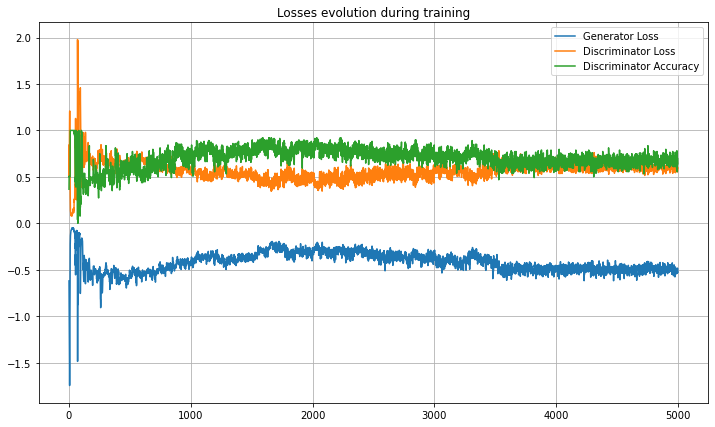

In [8]:
plt.figure(figsize=(12,7))
plt.plot(gan.g_losses, label='Generator Loss')
plt.plot(np.array(gan.d_losses)[:,0], label='Discriminator Loss')
plt.plot(np.array(gan.d_losses)[:,1], label='Discriminator Accuracy')
plt.title('Losses evolution during training')
plt.legend()
plt.grid()
plt.show()

The result is as we expected : generator and discriminator losses evolve in the inverse way. In fact, the more the generator is performant, the less the discriminator will be able to recognize which image is fake or real, hence both losses evolve in opposite ways. Here is the generation result after 5000 epochs:

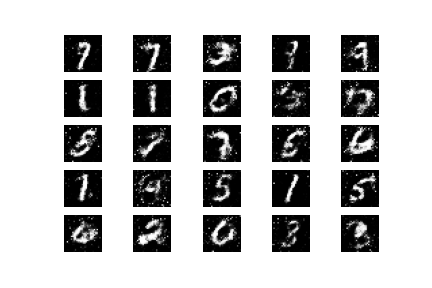

In [29]:
from IPython.display import display, Image
display(Image(filename='images/mnist_sample_005000.png', width=800))

The results look pretty interesting after 5000 epochs. Some noise is however still present in the images, which would disappear with more iterations. Note that we designed our own neural architecture for the discriminator and the generator; we decided to use fully connected neural nets, but of course many other things could have been used. For example, in the notebook that was in the last lab session of the course, convolutionaal architectures were proposed. Moreover, we could have add some layers or change the number of neurons in each layer.

## II- Neural Style Transfer

We worked on the article of Gatys et al. : A Neural Algorithm of Artistic Style, which was published in 2015 and had great success in the computer vision community. Note that since that, many variants that work better have been proposed. But our goal is not to develop the state-of-the art best algorithm, but really to focus on the basic ideas to perform neural style transfering. The following code is, in the majority, inspired by the Tensorflow website. We however tried to add modifications for instance, by using the VGG-19 pretrained weights for convolutions instead of ResNet or new convolutional architecture. We provide first our own theoretical interpretation, based on our reading of the original paper.

### II- 1. Some theory

<img src="transfer.png">

The idea behind this algorithm is to apply a style of an image to another image. In this prime example we take a paint and a picture and the goal is to apply the style of the painting to the picture. To do so, a the image is represented as a set
of filtered images at each processing stage in the CNN.

#### Content recontructions

Each layer in the network represents a non-linear filter and their complexity increases as we go deeper in the network. 
So in input we have an image $x$ that will be encoded in each of the layer of the network. 
We consider $N_l$ distinct filters in a layer $l$ and $N_l$ feature maps of size $M_l$ (=height x weight of the feature map). The response of the layer is stored in a matrix $F^l$ of shape $(N_l,M_l)$. Thus, the coordinate $F^l_{ij}$ corresponds to the activation of the $i$-th filter at position $j$ in the layer $l$.

To achieve the visualization we use a gradient descent on a white noise image in order to find a new image that matches the original image. To compare the differences between the two images $x$ and the original image $p$, we use the following loss:

$$\mathcal{L}_{content}(p,x,l) = \frac{1}{2}\sum_{i,j}(F^l_{ij} - P^l_{ij})^2$$

We change the image $x$ until it minimizes the loss above to match the image $p$. This process is visible on the image above "content reconstructions".

#### Style representation

The main idea then is to generate texture that match the style of a given image. So we use the Gram matrix of the feature correlations of the feature maps of a layer $l$: $G^l$.
We have $G^l_{ij} = \sum_k F^l_{ik}F^l_{jk}$

As we saw before, we use the same technique but on this matrix now. In fact, we use the mean-squared distance between $G$ from the original matrix and $G$ from the image to generate. We consider $a$ the original image and $x$ the image that is generated, and $A^l$ and $G^l$ their style representation in layer $l$, we have the total loss: 
$$\mathcal{L}_{style}(a,x)=\sum_{l=0}^Lw_lE_l$$ with $E_l= \frac{1}{4 N_l^2 M_l^2}\sum_{ij}(G^l_{ij} - A^l_{ij})^2$ and $w_l$ the weighting factor of the contribution of each layer to the total loss.

#### The global algorithm

Finally the result is a combination of both loss as follows: 

$$\mathcal{L}_{total}(a,x,p) = \alpha \mathcal{L}_{content}(p,x) + \beta \mathcal{L}_{style}(a,x)$$ 

with $\alpha$ and $\beta$ weighting factors. We choose them according to what is expected from the algorithm (to be closer to the painting or to the picture). Our implementation will be pretty natural as we will implement a content loss, a style loss, and a general loss. As we won't use a ready-to-use loss in keras, we will use the `tf.GradientTape()` functionality, which allows us to compute gradients w.r.t any loss function. The `run` function implements the training of the algorithm "manually", that is it updates the weights for each epoch using Adam optimizer and the derivative of the new-designed loss function.

### II- 2. Images to use

We decided to use the images of the building of ENSAE Paris and a landscape from Picasso. The Picasso painting is called *Paysage méditerranéen*, and was realized in 1963. We thought about this painting as it provides great characteristics of the Spanish master's brushstroke, gathered in one landscape, which is adapted to the ENSAE picture.

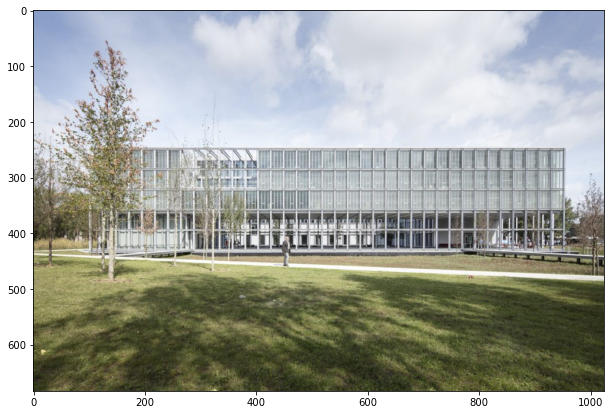

In [10]:
plt.figure(figsize=(12,7))
plt.imshow(plt.imread('ensae.jpg'))
plt.show()

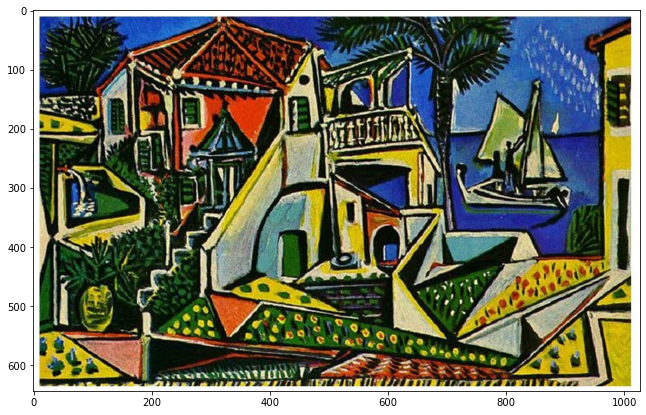

In [11]:
plt.figure(figsize=(12,7))
plt.imshow(plt.imread('picasso.jpg'))
plt.show()

### II- 3. The algorithm

Fo the algorithm we will use the VGG algorithm that has been pre-trained on imagenet and extract the layers that interest us.

In [12]:
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import PIL.Image
from PIL import Image
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [13]:
def preprocess(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [14]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [15]:
#a function to convert an image in a tensor

def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)

    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

In [16]:
content_path = 'ensae.jpg'
style_path = 'picasso.jpg'
content_image = load_img(content_path)
style_image = load_img(style_path)

We get the layers that interests us both for content and style :

In [17]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [18]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

We build the model based on the VGG19 algorithm that has been pre trained on imagenet.

In [19]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False #we do not train the algorithm
style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs
model = models.Model(vgg.input, model_outputs)

We need to define the loss function both for style and content thanks to the definition written above:

In [20]:
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [21]:
#Need the Gram Matrix for the style loss
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [22]:
def style_loss(base_style, gram):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram))

Then we implement a function to get the feature representations for style and content that will be useful later

In [23]:
def feature(model, content_path, style_path):

    content_image = preprocess(content_path)
    style_image = preprocess(style_path)

    style_outputs = model(style_image)
    content_outputs = model(content_image)

 
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In the following function we compute the loss by using both content and style loss previously defined:

In [24]:
def global_loss(model, loss_weights, init_image, gram_style_features, content_features):

    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * style_loss(comb_style[0], target_style)

    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score 
    return loss, style_score, content_score

In [25]:
def grad(cfg):
    with tf.GradientTape() as tape: 
        all_loss = global_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [26]:
def deprocessing(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8') #otherwise values in ]-infinite, +infinite[
    return x

In [27]:
import IPython.display

def run(content_path, style_path, num_iterations=100, content_weight=1e4, style_weight=1e-2): 
    for layer in model.layers:
        layer.trainable = False #still no training
   
    style_features, content_features = feature(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = preprocess(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    #the optimizer is Adam here, easier to implement than l-bfgs
    opt = tf.optimizers.Adam(learning_rate=7, beta_1=0.99, epsilon=1e-1)

    iter_count = 1
  
    best_loss, best_img = float('inf'), None
  
    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }
    
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   

    imgs = []
    for i in range(num_iterations):
        grads, all_loss = grad(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)

    if loss < best_loss:
        best_loss = loss
        best_img = deprocessing(init_image.numpy())

    if i % display_interval== 0:
      
        plot_img = init_image.numpy()
        plot_img = deprocessing(plot_img)
        imgs.append(plot_img)
        IPython.display.clear_output(wait=True)
        IPython.display.display_png(Image.fromarray(plot_img))
        print('Iteration: {}'.format(i))        
        print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            .format(loss, style_score, content_score))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(60,30))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss 

### II. 4 Results

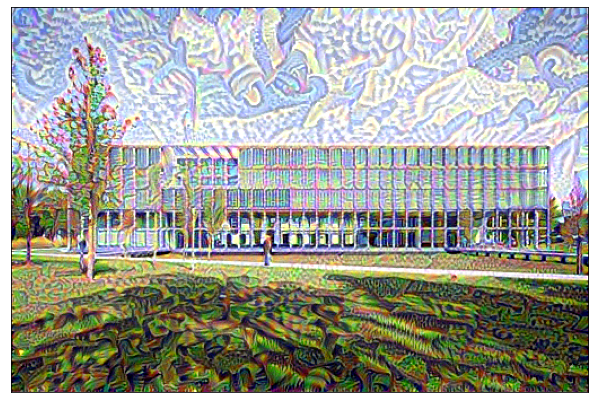

In [28]:
best, best_loss = run(content_path, style_path, num_iterations=10, content_weight=1e4, style_weight=1e-2)

An improvement can be done by using the l-bfgs optimizer instead of the Adam one but as we see on the images it works pretty well. The learning rate of the Adam optimizer can also be tuned ; we also tested the algorithm with higher learning rate, which leads to a painting style that is more pronounced. We can see that the ENSAE landscape seems to be painted in a Picasso-style. Note that the result is not a "mix" between *Paysage méditerranéen* and our school's bulding; it is precisely a Picasso touch in the picture reproduction, but not a mix of both, which is what we wanted to achieve.

## References

**[0]** Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio: *Generative Adversarial Networks*, 2014 arXiv:1406.2661   
**[1]** Leon A. Gatys, Alexander S. Ecker, Matthias Bethge: *A Neural Algorithm of Artistic Style*, 2015 arXiv:1508.06576  
**[2]** Yang Wang: *A Mathematical Introduction to Generative Adversarial Nets (GAN)*, 2020 	arXiv:2009.00169